# Senior Destination Local Indicators of Spatial Association
#### Daniel Fay

In [1]:
# Import necessary packages
import pandas as pd
import geopandas as gpd
import numpy as np
import pysal as ps
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [12]:
# Import data
destCount = gpd.read_file('../Data/shapefiles/elderly_dest_count.shp')
destCount.crs = {'init' :'epsg:4326'}
destinationCount = destCount.Count

In [5]:
# Import and convert to spatial weigths
spatialWeights = ps.queen_from_shapefile('../Data/shapefiles/elderly_dest_count.shp')

/Users/Danny1/anaconda/lib/python2.7/site-packages/pysal/weights/weights.py:189: UserWarning: There are 11 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/Danny1/anaconda/lib/python2.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 605, 606, 618, 753, 876, 911, 993, 1018, 1019, 1022, 1250
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [6]:
# Calculate spatial lag
spatialLag = ps.lag_spatial(spatialWeights, destinationCount)

In [7]:
# Calculate Local Morans I
localMorans = ps.Moran_Local(destinationCount, spatialWeights, permutations=999)

('WARNING: ', 605, ' is an island (no neighbors)')
('WARNING: ', 606, ' is an island (no neighbors)')
('WARNING: ', 618, ' is an island (no neighbors)')
('WARNING: ', 753, ' is an island (no neighbors)')
('WARNING: ', 876, ' is an island (no neighbors)')
('WARNING: ', 911, ' is an island (no neighbors)')
('WARNING: ', 993, ' is an island (no neighbors)')
('WARNING: ', 1018, ' is an island (no neighbors)')
('WARNING: ', 1019, ' is an island (no neighbors)')
('WARNING: ', 1022, ' is an island (no neighbors)')
('WARNING: ', 1250, ' is an island (no neighbors)')


/Users/Danny1/anaconda/lib/python2.7/site-packages/pysal/esda/moran.py:835: RuntimeWarning: invalid value encountered in divide
  self.z_sim = (self.Is - self.EI_sim) / self.seI_sim
/Users/Danny1/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Danny1/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Danny1/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1731: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


In [8]:
# Calculate Global Morans I
globalMorans = ps.Moran(destinationCount, spatialWeights)

In [9]:
# Find significant values
sigs = destinationCount[localMorans.p_sim <= .05]
insigs = destinationCount[localMorans.p_sim > .05]

W_sigs = spatialLag[localMorans.p_sim <= .05]
W_insigs = spatialLag[localMorans.p_sim > .05]

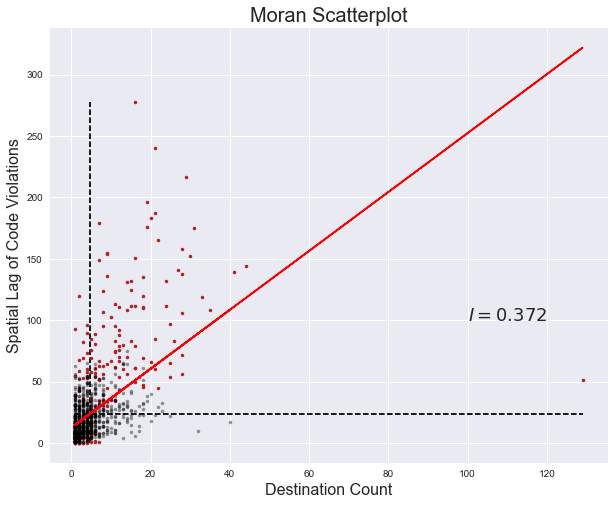

In [10]:
b,a = np.polyfit(destinationCount, spatialLag, 1)

f, ax = plt.subplots(figsize=(10, 8))
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.4)
plt.text(s='$I = %.3f$' % globalMorans.I, x=100, y=100, fontsize=18)

 # dashed vert at mean of the last year's PCI
plt.vlines(destinationCount.mean(), spatialLag.min(), spatialLag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(spatialLag.mean(), destinationCount.min(), destinationCount.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(destinationCount, a + b*destinationCount, 'r')
plt.title('Moran Scatterplot', fontsize=20)
plt.ylabel('Spatial Lag of Code Violations', fontsize=16)
plt.xlabel('Destination Count', fontsize=16)

In [11]:
sig = localMorans.p_sim < 0.05
insig = localMorans.p_sim >= 0.05
hot_hot = localMorans.q==1 * sig
cold_cold = localMorans.q==3 * sig
hot_cold= localMorans.q==2 * sig
cold_hot = localMorans.q==4 * sig

print ("Number of Hot-Hot spots:", hot_hot.sum())
print ("Number of Cold-Cold spots:", cold_cold.sum())
print ("Number of Hot-Cold spots:", hot_cold.sum())
print ("Number of Cold-Hot spots:", cold_hot.sum())

('Number of Hot-Hot spots:', 106)
('Number of Cold-Cold spots:', 74)
('Number of Hot-Cold spots:', 18)
('Number of Cold-Hot spots:', 15)


In [13]:
destCount['hot_hot'] = hot_hot.astype(int)
destCount['hot_cold'] = hot_cold.astype(int)
destCount['cold_cold'] = cold_cold.astype(int)
destCount['cold_hot'] = cold_hot.astype(int)
destCount['insig'] = insig.astype(int)
destCount['localMorans'] = localMorans.Is
destCount.head()

,BoroCode,BoroName,Count,DTRACT,Shape_Area,Shape_Leng,geometry,index_righ,hot_hot,hot_cold,cold_cold,cold_hot,insig,localMorans
0,5,Staten Island,6,36085013800,1.623819e+09,330476.02653,"POLYGON ((-74.12177 40.57505400000001, -74.121...",0,1,0,0,0,0,0.157596
1,5,Staten Island,2,36085019700,1.623819e+09,330476.02653,POLYGON ((-74.13122400000002 40.61726499999998...,0,0,0,0,0,1,-0.312404
2,5,Staten Island,13,36085013204,1.623819e+09,330476.02653,POLYGON ((-74.12005199999996 40.56039400000002...,0,0,0,0,0,1,0.439972
3,5,Staten Island,6,36085020100,1.623819e+09,330476.02653,"POLYGON ((-74.13046100000003 40.630897, -74.13...",0,0,0,0,0,1,0.074512
4,5,Staten Island,4,36085018100,1.623819e+09,330476.02653,POLYGON ((-74.10090499999998 40.59101999999996...,0,0,1,0,0,0,-0.080949


In [14]:
destCount.to_file('../Data/shapefiles/hot_cold_spots.shp')

In [16]:
destCount_LM = destCount[['DTRACT', 'localMorans', 'geometry']]
destCount_LM.to_file('../Data/shapefiles/local_morans.shp')